In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from keras.layers import Input, Dense, Dropout, LSTM, ConvLSTM1D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib
from attention import Attention


ImportError: cannot import name 'Attention' from 'attention' (/Users/williambrach/miniforge3/lib/python3.8/site-packages/attention/__init__.py)

In [2]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction,title="Graph"):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [5]:
df = pd.read_csv("../../data/data_processed_cleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.05
df['mve'] = df['mve'] * 0.1
df['wpg'] = df['wpg'] * 0.1

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 


df_test = pd.read_csv("../../data/data_processed_cleaned_fake.csv")
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y/%m/%d %H:%M')

In [6]:
features_considered = [
                    'price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
### Train dataset 
features = df[features_considered]
features.index = df['date']

scaler_prod = StandardScaler()
scaler_2 = MinMaxScaler()

prod_dataset = scaler_prod.fit_transform(df['production_usage'].values.reshape(-1,1))
prod_dataset = scaler_2.fit_transform(prod_dataset)

scaler_cons = StandardScaler()
scaler_2 = MinMaxScaler()
cons_dataset = scaler_cons.fit_transform(df['consumption_usage'].values.reshape(-1,1))
cons_dataset = scaler_2.fit_transform(cons_dataset)

scaler_all = StandardScaler()
scaler_2 = MinMaxScaler()
dataset = scaler_all.fit_transform(features.values)
dataset = scaler_2.fit_transform(features.values)

### Test dataset
features = df_test[features_considered]
features.index = df_test['date']

scaler_2 = MinMaxScaler()
scaler_prod = StandardScaler()
prod_dataset_test = scaler_prod.fit_transform(df_test['production_usage'].values.reshape(-1,1))
prod_dataset_test = scaler_2.fit_transform(prod_dataset_test)

scaler_2 = MinMaxScaler()
scaler_cons = StandardScaler()
cons_dataset_test = scaler_cons.fit_transform(df_test['consumption_usage'].values.reshape(-1,1))
cons_dataset_test = scaler_2.fit_transform(cons_dataset_test)

scaler_2 = MinMaxScaler()
dataset_test = scaler_all.fit_transform(features.values)
dataset_test = scaler_2.fit_transform(features.values)

In [7]:
past_history = 96
future_target = 4
STEP = 1




x, y1 = multivariate_data(dataset, prod_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x, y2 = multivariate_data(dataset, cons_dataset, 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val , y1_val = multivariate_data(dataset_test, prod_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_val , y2_val = multivariate_data(dataset_test, cons_dataset_test,
                                               0, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [8]:

inputs = Input(shape=(past_history,len(features_considered)))
conv1 = Conv1D(16, kernel_size=4, activation='relu')(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
m = Dropout(0.2)(pool1)
m = LSTM(256,  return_sequences=False)(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=1,steps_per_epoch=100)

100/100 [==============================] - 4s 33ms/step - loss: 0.0501 - dense_loss: 0.0270 - dense_1_loss: 0.0230


<ipython-input-9-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.24096199]
 [0.24109716]
 [0.24148903]
 [0.24212194]]


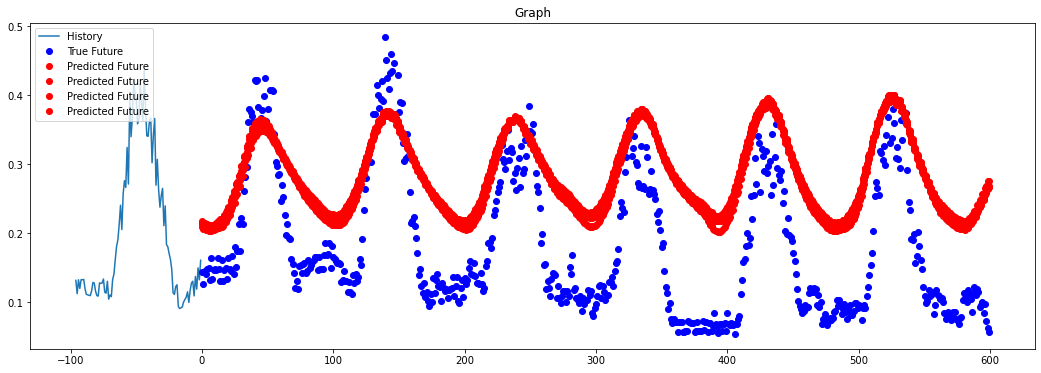

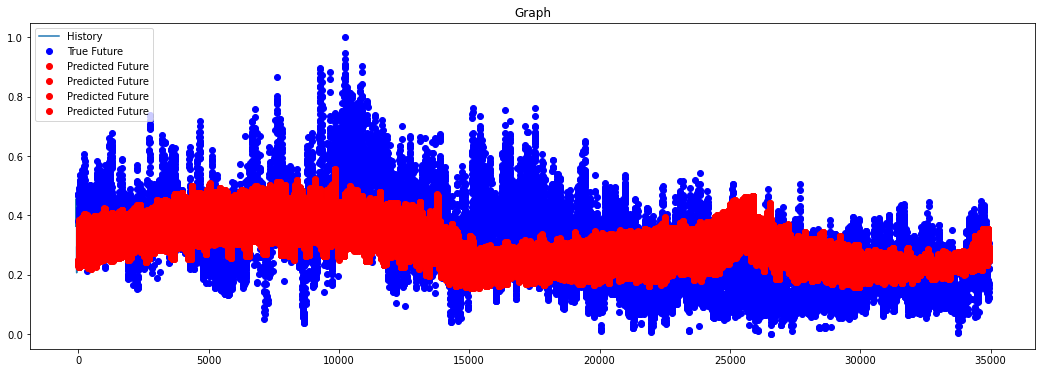

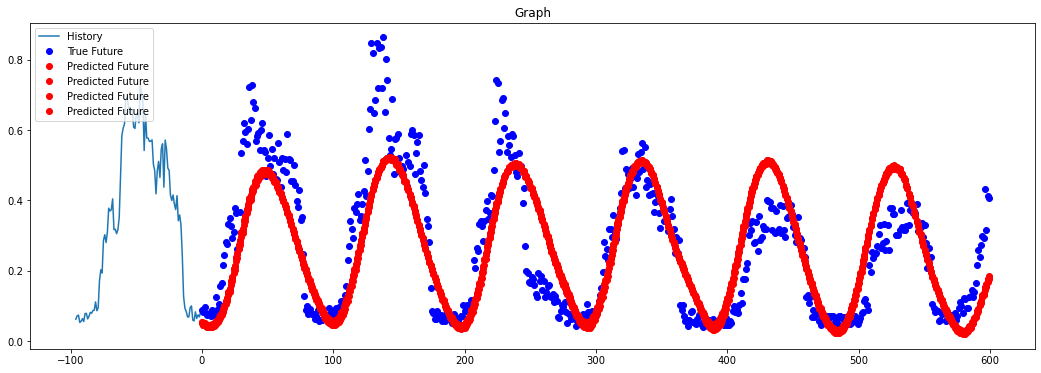

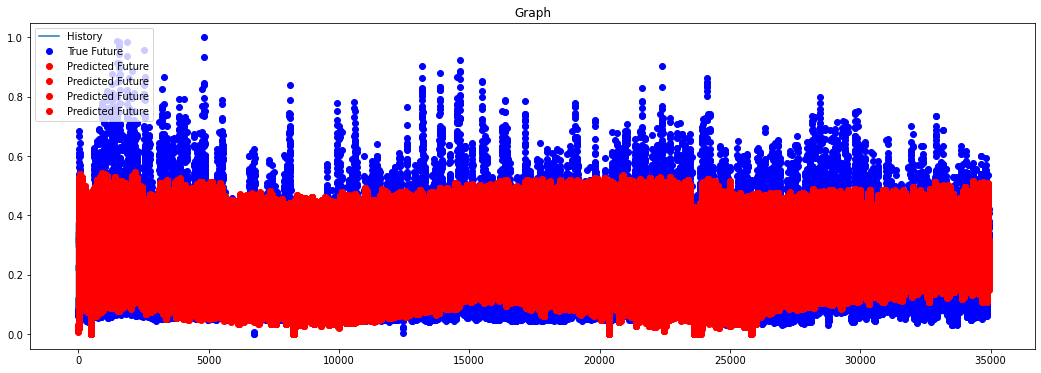

In [9]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [10]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=False)(inputs)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 4s 31ms/step - loss: 0.0713 - dense_2_loss: 0.0345 - dense_3_loss: 0.0368
Epoch 2/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0466 - dense_2_loss: 0.0226 - dense_3_loss: 0.0240
Epoch 3/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0369 - dense_2_loss: 0.0200 - dense_3_loss: 0.0170
Epoch 4/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0349 - dense_2_loss: 0.0195 - dense_3_loss: 0.0154
Epoch 5/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0339 - dense_2_loss: 0.0191 - dense_3_loss: 0.0148
Epoch 6/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0333 - dense_2_loss: 0.0188 - dense_3_loss: 0.0145
Epoch 7/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0328 - dense_2_loss: 0.0185 - dense_3_loss: 0.0143
Epoch 8/10
100/100 [==============================] - 3s 28ms/step - loss: 0.0323 - dense_2_loss: 0.0182

<ipython-input-11-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.34580263]
 [0.34740784]
 [0.3492694 ]
 [0.35138293]]


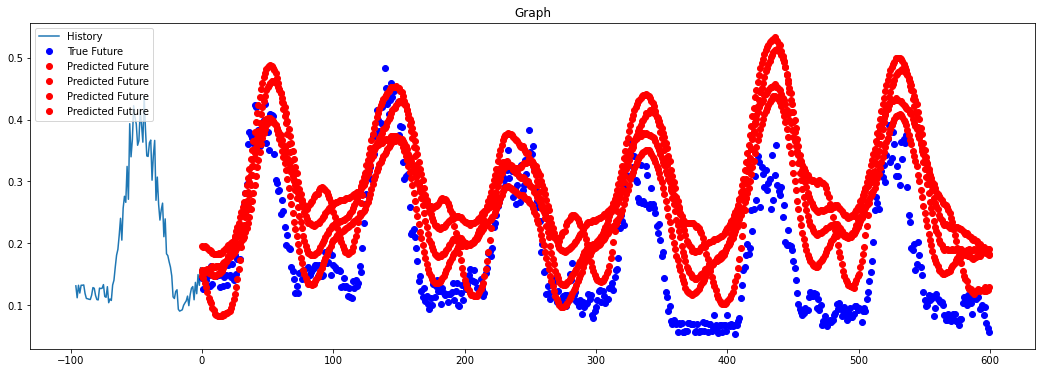

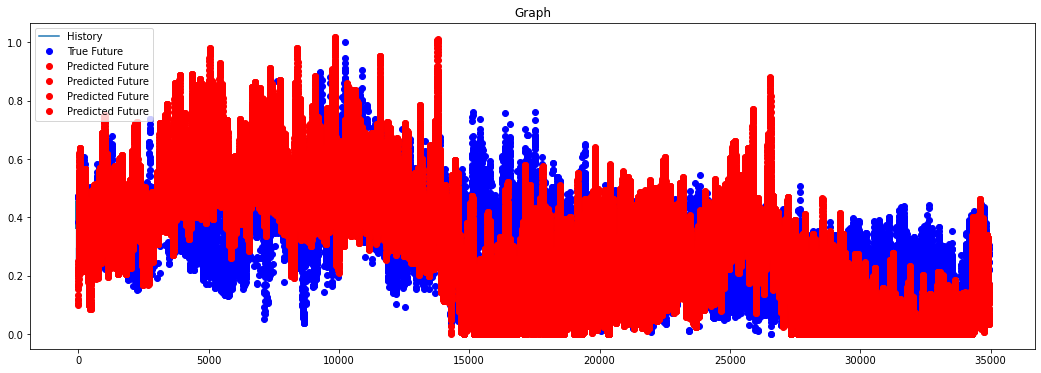

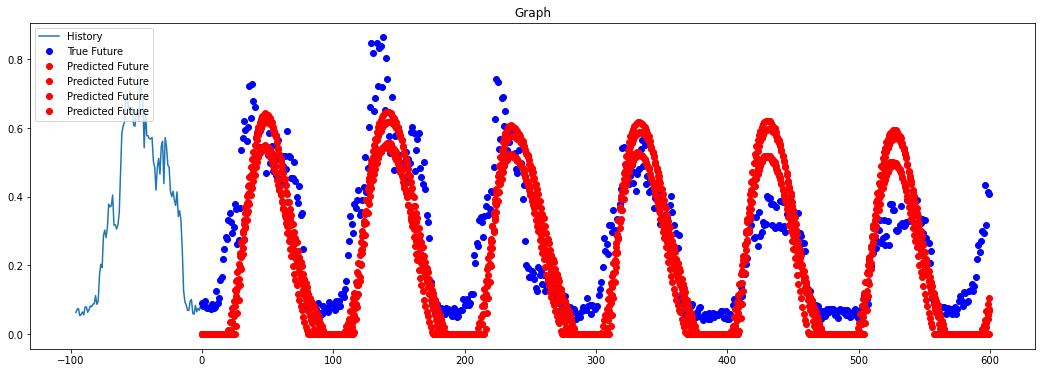

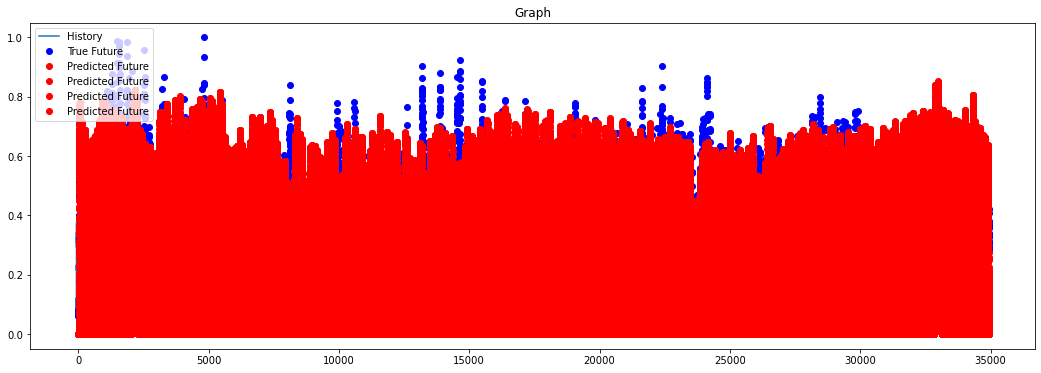

In [11]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [12]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=True)(inputs)
m = LSTM(128)(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 8s 61ms/step - loss: 0.0941 - dense_4_loss: 0.0494 - dense_5_loss: 0.0447
Epoch 2/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0437 - dense_4_loss: 0.0231 - dense_5_loss: 0.0206
Epoch 3/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0395 - dense_4_loss: 0.0209 - dense_5_loss: 0.0185
Epoch 4/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0312 - dense_4_loss: 0.0176 - dense_5_loss: 0.0136
Epoch 5/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0303 - dense_4_loss: 0.0167 - dense_5_loss: 0.0136
Epoch 6/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0295 - dense_4_loss: 0.0163 - dense_5_loss: 0.0132
Epoch 7/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0300 - dense_4_loss: 0.0168 - dense_5_loss: 0.0132
Epoch 8/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0277 - dense_4_loss: 0.0146

<ipython-input-13-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.38025181]
 [0.38146481]
 [0.38289983]
 [0.3845309 ]]


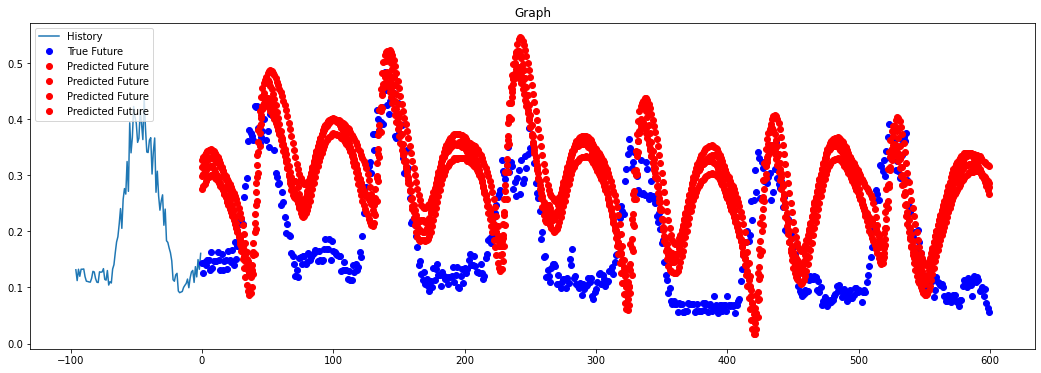

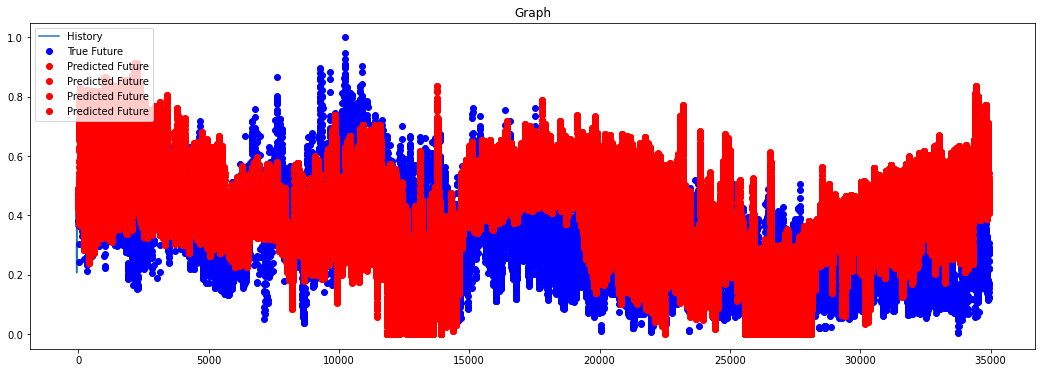

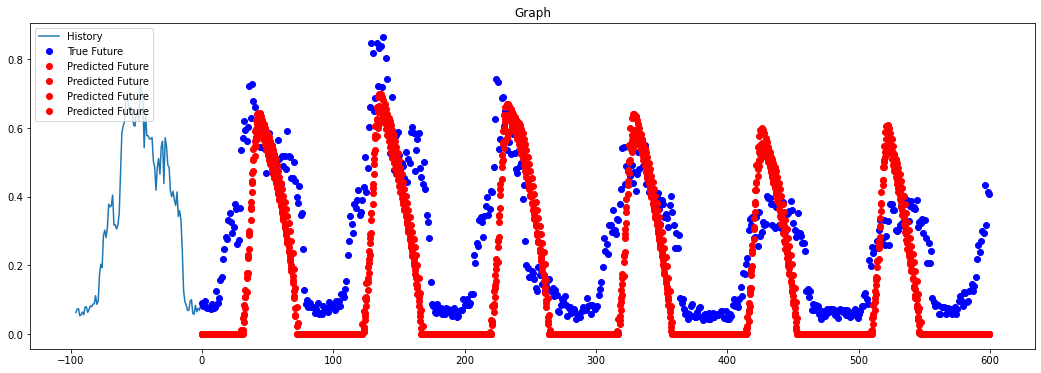

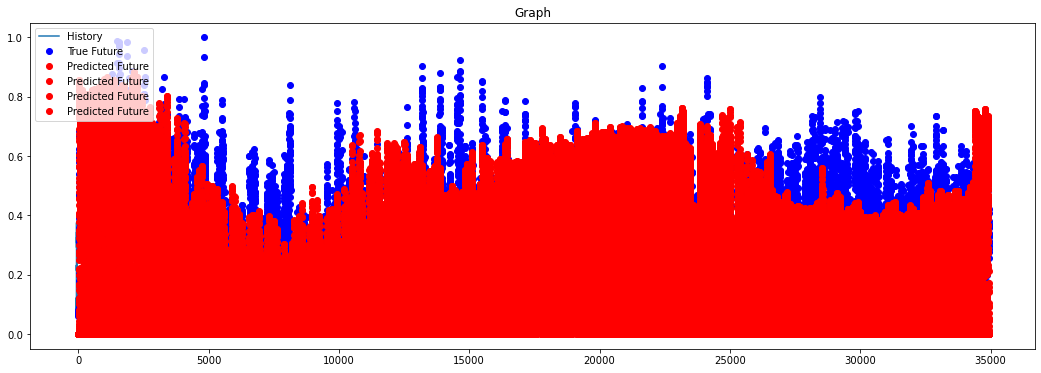

In [13]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])

In [14]:
inputs = Input(shape=(past_history,len(features_considered)))
m = LSTM(64,  return_sequences=True)(inputs)
m = LSTM(128)(m)
m = Dense(96, activation='relu')(m)
outputA = Dense(future_target, activation='relu')(m)
outputB = Dense(future_target, activation='relu')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')


history = m.fit(x,[y1,y2], epochs=10,steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 8s 63ms/step - loss: 0.0933 - dense_7_loss: 0.0492 - dense_8_loss: 0.0441
Epoch 2/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0481 - dense_7_loss: 0.0259 - dense_8_loss: 0.0222
Epoch 3/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0518 - dense_7_loss: 0.0261 - dense_8_loss: 0.0256
Epoch 4/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0299 - dense_7_loss: 0.0140 - dense_8_loss: 0.0160
Epoch 5/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0303 - dense_7_loss: 0.0140 - dense_8_loss: 0.0163
Epoch 6/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0252 - dense_7_loss: 0.0121 - dense_8_loss: 0.0131
Epoch 7/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0236 - dense_7_loss: 0.0111 - dense_8_loss: 0.0126
Epoch 8/10
100/100 [==============================] - 6s 57ms/step - loss: 0.0230 - dense_7_loss: 0.0108

<ipython-input-15-621f5b6c8295>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual = np.array(actual)


Average rmse
[[0.3995324 ]
 [0.39984365]
 [0.40040151]
 [0.40120596]]


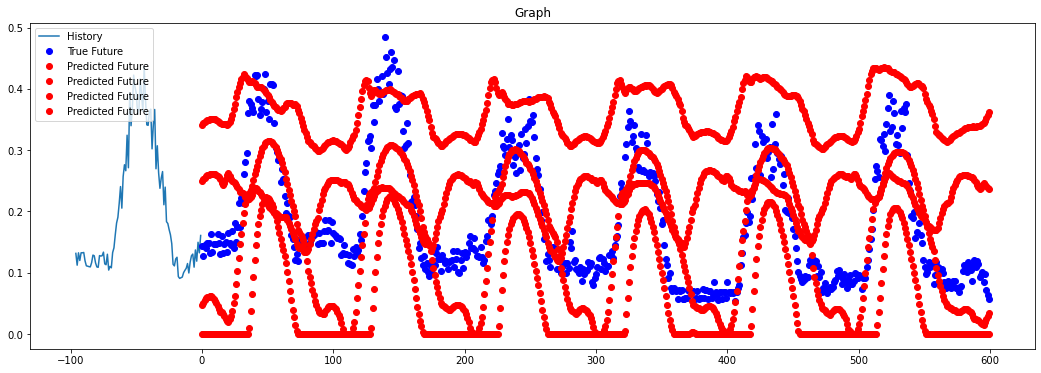

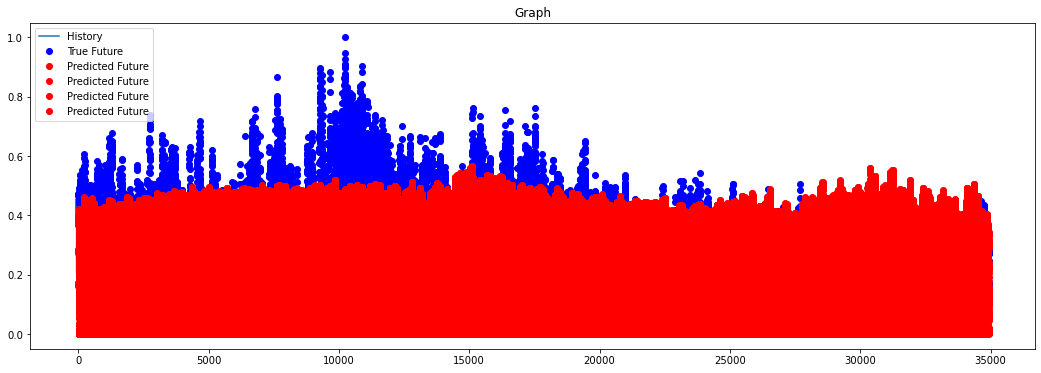

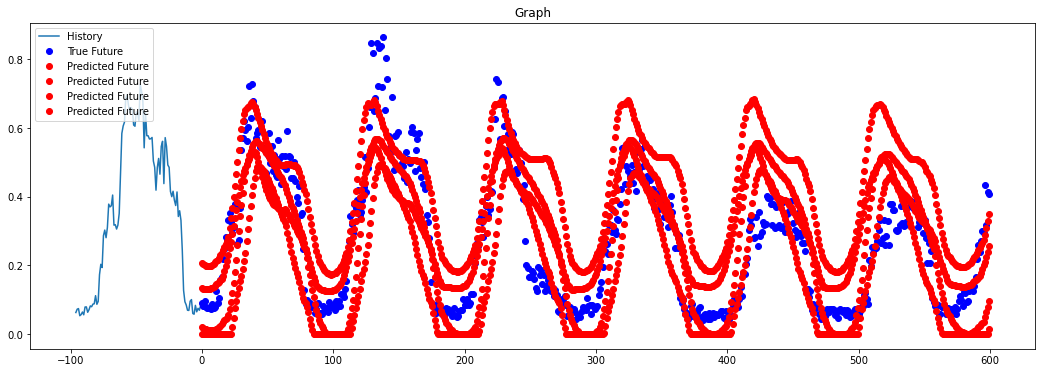

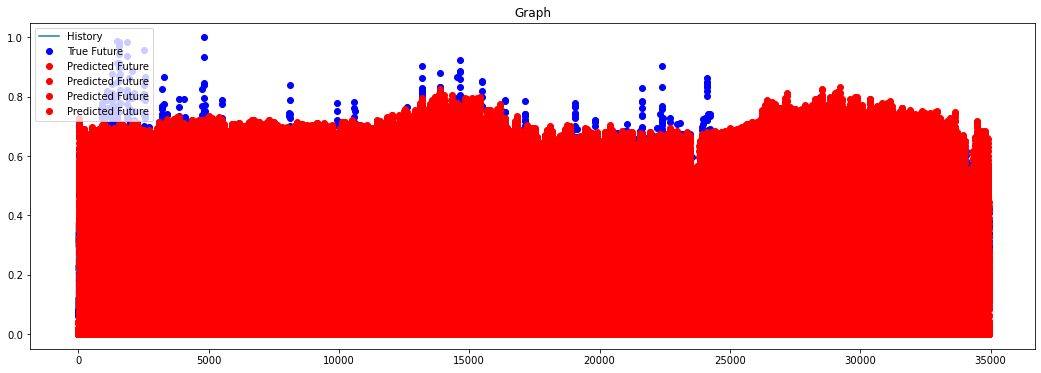

In [15]:
pred = m.predict(x_val)
actual = []
for index,val in enumerate(y1_val):
    actual.append([y1_val[index:index+future_target]])
actual = np.array(actual)
print("Average rmse")
print(rmse(pred[0][:-future_target],actual[:-future_target]))

multi_step_plot(prod_dataset_test[24000:][:96], y1_val[24000:][:600], pred[0][24000:][:600])
multi_step_plot(prod_dataset_test[:96], y1_val, pred[0])
multi_step_plot(cons_dataset_test[24000:][:96], y2_val[24000:][:600], pred[1][24000:][:600])
multi_step_plot(cons_dataset_test[:96], y2_val, pred[1])